# SimBA Attack Test Notebook

This notebook demonstrates how to use the SimBA (Simple Black-box Adversarial) attack implementation.

In [1]:
import sys
import os
import importlib

# Add project root to Python path
# Get the current notebook's directory and go up one level to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import torch
import torch.nn.functional as F
from src.models.loader import get_model
from src.utils.imaging import preprocess_image, show_image, denormalize_image, get_imagenet_label
from PIL import Image
import matplotlib.pyplot as plt

# Reload SimBA module to ensure we're using the latest code
import src.attacks.simba
importlib.reload(src.attacks.simba)
from src.attacks.simba import SimBA

## Load Model

Load a pretrained ResNet50 model for demonstration.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = get_model('resnet50', device=device)
print("Model loaded successfully!")

Using device: cpu


/home/florent/miniconda3/envs/abbd/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/florent/miniconda3/envs/abbd/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully!


## Load and Preprocess Image

Load an image and preprocess it for the model. You can replace the image path with your own image.

Predicted class: 281 (tabby cat)
Confidence: 0.8398


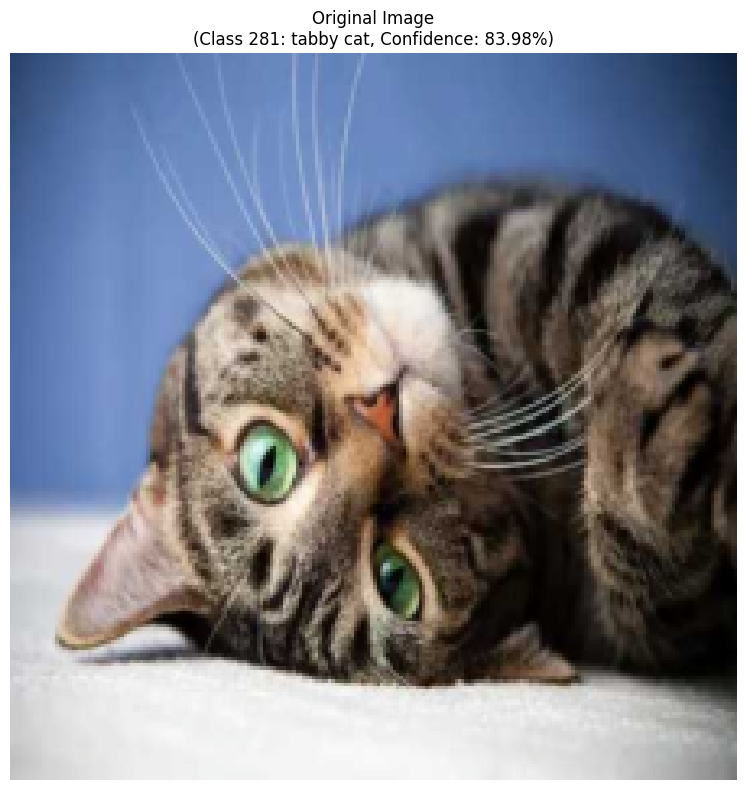

In [3]:
# Load the test image
image_path = '../data/cat.jpg'
image = Image.open(image_path).convert('RGB')
image_tensor = preprocess_image(image, device=device)

# Get model prediction
with torch.no_grad():
    logits = model(image_tensor)
    probs = F.softmax(logits, dim=1)
    predicted_class = torch.argmax(logits, dim=1).item()
    confidence = probs[0][predicted_class].item()

# Get human-readable label
predicted_label = get_imagenet_label(predicted_class)

print(f"Predicted class: {predicted_class} ({predicted_label})")
print(f"Confidence: {confidence:.4f}")

# Display original image
show_image(image_tensor, title=f"Original Image\n(Class {predicted_class}: {predicted_label}, Confidence: {confidence:.2%})", denormalize=True)

## Run SimBA Attack

Generate an adversarial example using the SimBA attack.

In [4]:
# Initialize SimBA attack
epsilon = 0.5  # Try changing this value - it should affect the attack!
attack = SimBA(
    model=model,
    epsilon=epsilon,
    max_iterations=2000,
    device=device,
    use_dct=False  # Use pixel space for simplicity
)

print(f"=== Attack Configuration ===")
print(f"Epsilon passed to SimBA: {epsilon}")
print(f"Attack.epsilon stored value: {attack.epsilon}")
print(f"Image shape: {image_tensor.shape}")
print(f"Image is normalized: {image_tensor.min().item() < -1.0}")  # Normalized images have negative values

# Generate adversarial example with confidence tracking
y_true = torch.tensor([predicted_class], device=device)
x_adv = attack.generate(image_tensor, y_true, track_confidence=True)

# Debug: Check if confidence_history was set
print(f"Has confidence_history after generate: {hasattr(attack, 'confidence_history')}")
if hasattr(attack, 'confidence_history'):
    print(f"confidence_history value: {attack.confidence_history}")

# Check if attack was successful
is_adversarial = attack.check_adversarial(x_adv, y_true)
print(f"Attack successful: {is_adversarial.item()}")

# Get prediction on adversarial example
with torch.no_grad():
    logits_adv = model(x_adv)
    probs_adv = F.softmax(logits_adv, dim=1)
    predicted_class_adv = torch.argmax(logits_adv, dim=1).item()
    confidence_adv = probs_adv[0][predicted_class_adv].item()

# Get confidence for original class (tabby cat) on adversarial example
original_class_confidence_adv = probs_adv[0][predicted_class].item()

# Get human-readable label for adversarial prediction
predicted_label_adv = get_imagenet_label(predicted_class_adv)

print(f"\n=== Attack Results ===")
print(f"Original class: {predicted_class} ({predicted_label})")
print(f"  - Confidence BEFORE attack: {confidence:.4f}")
print(f"  - Confidence AFTER attack:  {original_class_confidence_adv:.4f}")
print(f"  - Confidence drop: {confidence - original_class_confidence_adv:.4f}")
print(f"\nNew predicted class: {predicted_class_adv} ({predicted_label_adv})")
print(f"  - Confidence: {confidence_adv:.4f}")

# Calculate perturbation
perturbation = x_adv - image_tensor
perturbation_norm = torch.norm(perturbation, p=float('inf')).item()
print(f"\nL∞ perturbation norm: {perturbation_norm:.6f}")

=== Attack Configuration ===
Epsilon passed to SimBA: 0.5
Attack.epsilon stored value: 0.5
Image shape: torch.Size([1, 3, 224, 224])
Image is normalized: True
DEBUG: _create_perturbation using epsilon=0.5
Has confidence_history after generate: True
confidence_history value: {'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641, 651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771, 781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891, 901, 911, 921, 931, 941, 951, 961, 971, 981, 991, 1001, 1011, 1021, 1031, 1041, 1051, 1061, 107

## Plot Confidence Evolution

Visualize how the confidence of the original class and the maximum confidence of other classes change during the attack.

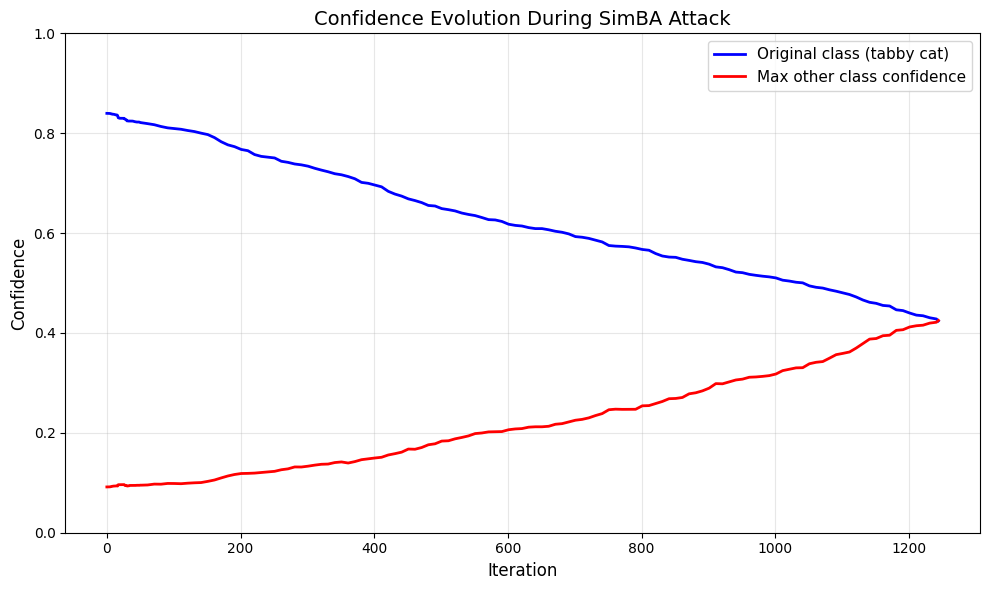

Total iterations tracked: 172
Final iteration: 1244
Final original class confidence: 0.4242
Final max other class confidence: 0.4251


In [5]:
# Plot confidence evolution during attack
if hasattr(attack, 'confidence_history') and attack.confidence_history is not None:
    iterations = attack.confidence_history.get('iterations', [])
    original_conf = attack.confidence_history.get('original_class', [])
    max_other_conf = attack.confidence_history.get('max_other_class', [])
    
    if iterations and len(iterations) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.plot(iterations, original_conf, 'b-', label=f'Original class ({predicted_label})', linewidth=2)
        ax.plot(iterations, max_other_conf, 'r-', label='Max other class confidence', linewidth=2)
        
        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('Confidence', fontsize=12)
        ax.set_title('Confidence Evolution During SimBA Attack', fontsize=14)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()
        
        print(f"Total iterations tracked: {len(iterations)}")
        print(f"Final iteration: {iterations[-1] if iterations else 0}")
        print(f"Final original class confidence: {original_conf[-1]:.4f}")
        print(f"Final max other class confidence: {max_other_conf[-1]:.4f}")
    else:
        print(f"Confidence history exists but is empty. History keys: {list(attack.confidence_history.keys())}")
        print(f"Make sure track_confidence=True was used and the attack ran for at least one iteration.")
else:
    print("Confidence history not available.")
    print(f"Has confidence_history attribute: {hasattr(attack, 'confidence_history')}")
    if hasattr(attack, 'confidence_history'):
        print(f"confidence_history value: {attack.confidence_history}")
    print("Make sure track_confidence=True was used when calling attack.generate().")

## Visualize Results

Compare the original image, adversarial example, and perturbation.

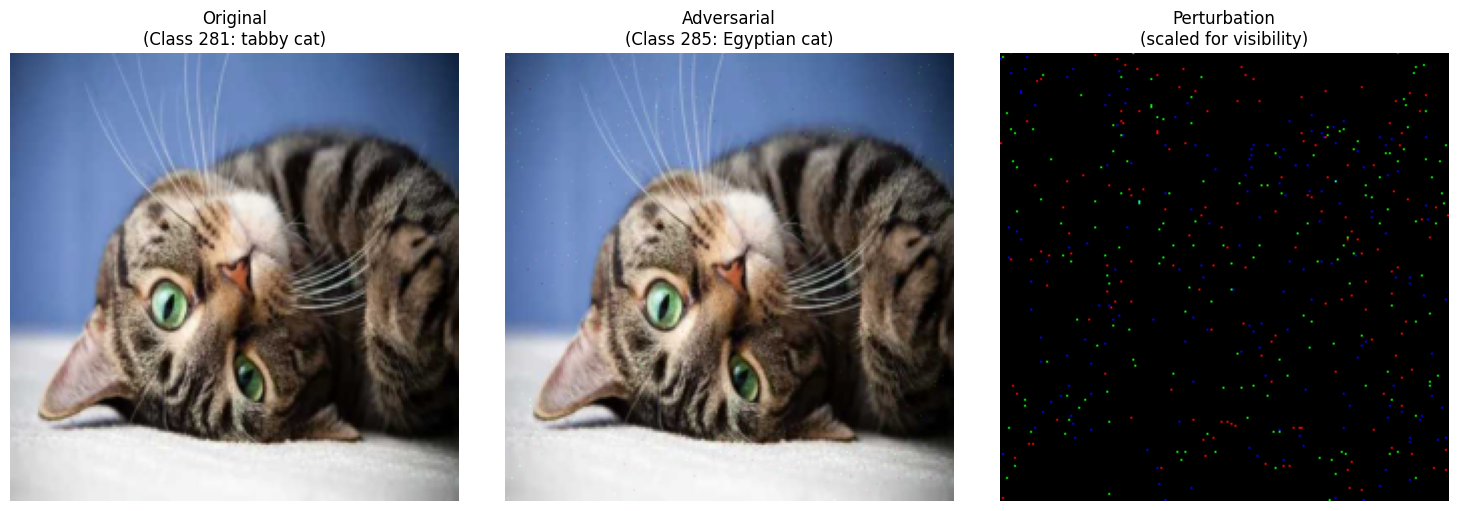

In [6]:
import numpy as np

# Prepare images for display
def prepare_for_display(img_tensor, denormalize=False):
    """Convert tensor to numpy array for display."""
    if denormalize:
        img_tensor = denormalize_image(img_tensor)
    # Remove batch dimension if present
    if img_tensor.dim() == 4:
        img_tensor = img_tensor[0]
    # Convert to numpy and transpose CHW -> HWC
    img_np = img_tensor.cpu().detach().numpy()
    if img_np.shape[0] == 3:  # CHW format
        img_np = np.transpose(img_np, (1, 2, 0))
    # Ensure values are in [0, 1] range
    if img_np.max() > 1.0:
        img_np = img_np / 255.0
    return np.clip(img_np, 0.0, 1.0)

# Prepare all images
img_orig = prepare_for_display(image_tensor, denormalize=True)
img_adv = prepare_for_display(x_adv, denormalize=True)
img_pert = prepare_for_display(perturbation, denormalize=False)

# For perturbation, scale it for better visibility
img_pert_scaled = (img_pert - img_pert.min()) / (img_pert.max() - img_pert.min() + 1e-8)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img_orig)
axes[0].set_title(f"Original\n(Class {predicted_class}: {predicted_label})")
axes[0].axis('off')

# Adversarial image
axes[1].imshow(img_adv)
axes[1].set_title(f"Adversarial\n(Class {predicted_class_adv}: {predicted_label_adv})")
axes[1].axis('off')

# Perturbation (scaled for visibility)
axes[2].imshow(img_pert_scaled)
axes[2].set_title("Perturbation\n(scaled for visibility)")
axes[2].axis('off')

plt.tight_layout()
plt.show()